<center><img src="images/header.png"></center>

<h1><center>Алгоритмы интеллектуальной обработки больших объемов данных</center></h1>
<hr>
<h2><center>Деревья решений, случайные леса (практика)</center></h2>

**Срок сдачи:** 3 апреля 2017, 06:00 <br> 
**Штраф за опоздание:** -2 балла после 06:00 3 апреля, -4 балла после 06:00 10 апреля, -6 баллов после 06:00 17 апреля

При отправлении ДЗ указывайте фамилию в названии файла<br>

Не забудте создать задание в Slack через /todo.

Используйте данный Ipython Notebook при оформлении домашнего задания.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

# Практика

### Качество вина (10 баллов)

Давайте все-таки разберемся с [вином](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv)!


#### Задание (1 балл)
* Загрузите данные, выполните преобразование целевой переменной: 
    * quality > 5 -> 1
    * quality <= 5 -> 0
* Разделите выборку на обучающую и контрольную в пропорции 80/20

In [2]:
# Your Code Here
df_wine = pd.read_csv('winequality-red.csv', sep=';')
df_wine.loc[:, 'quality'] = (df_wine.loc[:, 'quality'] > 5).astype(int) 
data=df_wine.values
X,Y=data[:,:-1],data[:,-1]
np.random.shuffle(data)
pos=int(data.shape[0]*0.8)
X_train,Y_train,X_test,Y_test=data[:pos,:-1],data[:pos,-1],data[pos:,:-1],data[pos:,-1]

#### Задание (2 балла)

Сфокусируемся на одном гиперпараметре деревьев решений - максимальной глубине.

Подберите наилучшую глубину `d` дерева с помошью 
* Усредненной оценки качества roc-auc на кросс-валидации при различных `d`
* Валидационных кривых

In [3]:
from sklearn.tree import DecisionTreeClassifier

try:
    from sklearn.model_selection import cross_val_score
except ImportError:
    from sklearn.cross_validation import cross_val_score

try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve

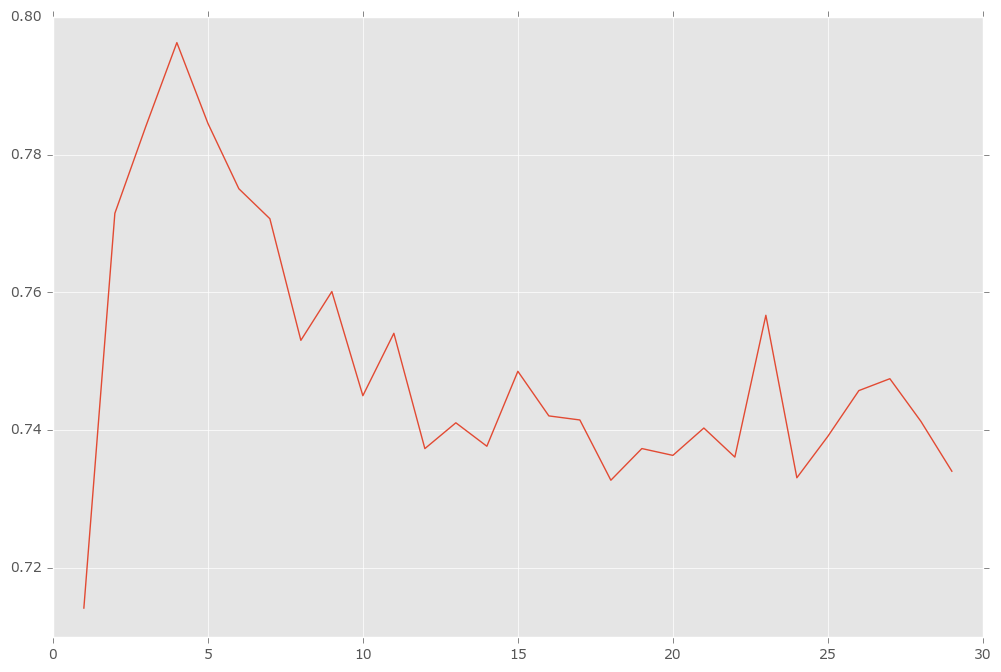

In [6]:
# Your Code Here
depthRange=range(1, 30)
scoremeans=[]
for i in depthRange:
    scoremeans.append(cross_val_score(DecisionTreeClassifier(max_depth=i), X_train, Y_train,cv=5, scoring='roc_auc').mean())

plt.plot(depthRange,scoremeans)

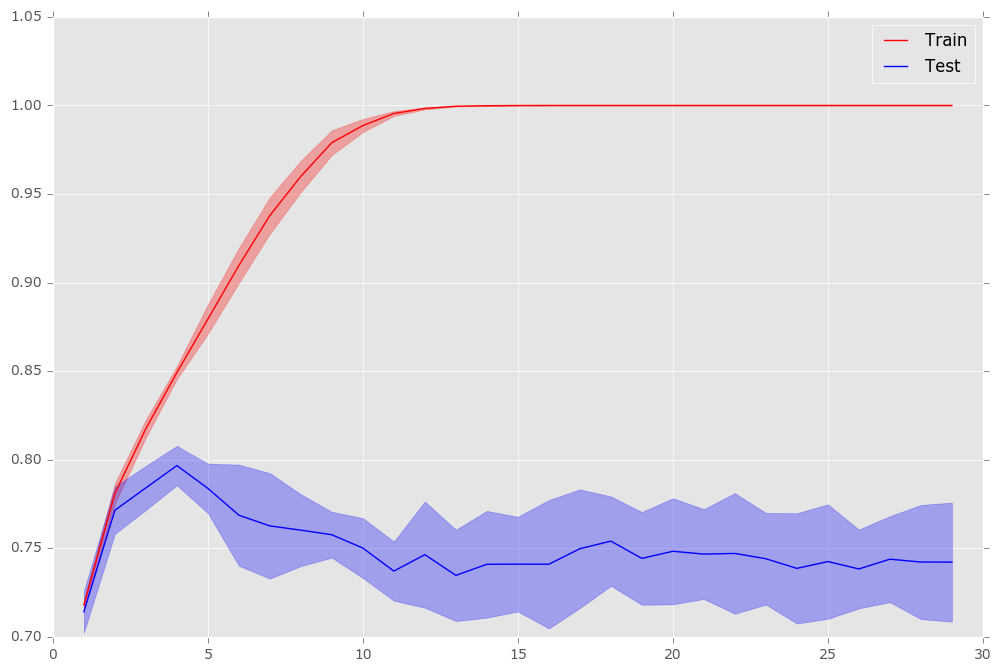

In [7]:
model = DecisionTreeClassifier()
train_scores, test_scores = validation_curve(model,X_train,Y_train,'max_depth',depthRange,n_jobs=-1, cv=5, scoring='roc_auc')

train_scores_mean,test_scores_mean=train_scores.mean(axis=1),test_scores.mean(axis=1)
train_scores_std,test_scores_std=train_scores.std(axis=1),test_scores.std(axis=1)

plt.plot(depthRange,train_scores_mean,c='r',label="Train")
plt.fill_between(depthRange,train_scores_mean-train_scores_std,train_scores_mean+train_scores_std,color='r',alpha=0.3)
plt.plot(depthRange,test_scores_mean,c='b',label="Test")
plt.fill_between(depthRange,test_scores_mean-test_scores_std,test_scores_mean+test_scores_std,color='b',alpha=0.3)
plt.legend()
plt.show()

При глубине 4 показатель классификации на тестовой выборке хороший и переобучение не так сильно

In [8]:
bestDepth=4

#### Задание (1 балл)

Отсортируйте признаки по важности. Вектор с важностью признаков можно получить с помощью `model.feature_importances_`

In [9]:
# Your Code Here
model = DecisionTreeClassifier(max_depth=bestDepth)
model.fit(X=X, y=Y)
print("Признаки в порядке убывани важности: "+",".join(df_wine.columns[np.argsort(model.feature_importances_)[::-1]]))

Признаки в порядке убывани важности: alcohol,sulphates,total sulfur dioxide,fixed acidity,volatile acidity,chlorides,pH,density,free sulfur dioxide,residual sugar,citric acid


#### Задание (2 балла)
* Получите предсказания на тестовой выборке
* Постройте ROC кривые для обучающей и тестовой выборок
* Посчитайте остальные меры качества классификации при пороге в `0.5`

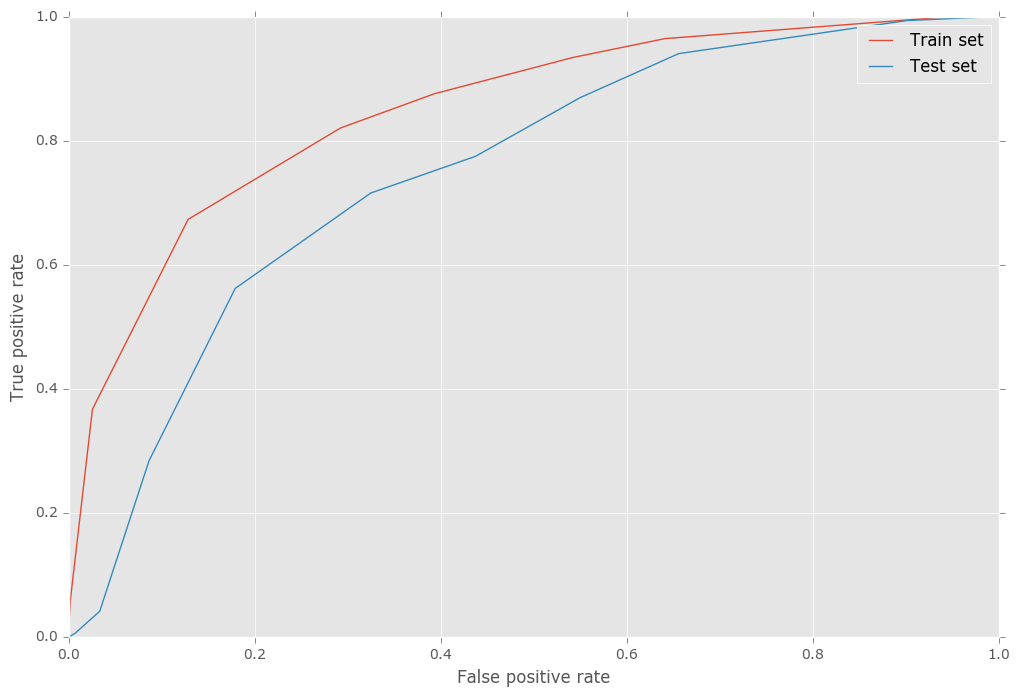

In [10]:
# Your Code Here
from sklearn.metrics import roc_curve

model = DecisionTreeClassifier(max_depth=bestDepth)
model.fit(X_train, Y_train)

pred_train=model.predict_proba(X_train)
pred_test=model.predict_proba(X_test)

train_roc=roc_curve(Y_train,pred_train[:,1])
test_roc=roc_curve(Y_test,pred_test[:,1])

plt.plot(train_roc[0],train_roc[1])
plt.plot(test_roc[0],test_roc[1])
plt.legend(["Train set","Test set"])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

In [11]:
from sklearn.metrics import accuracy_score,recall_score,precision_score

half_thr_pred=(pred_test[:,1]>0.5).astype(int)
print("Accuracy score: "+str(accuracy_score(Y_test,half_thr_pred)))
print("Recall score: "+str(recall_score(Y_test,half_thr_pred)))
print("Precision score: "+str(precision_score(Y_test,half_thr_pred)))

Accuracy score: 0.696875
Recall score: 0.715976331361
Precision score: 0.711764705882


#### Задание (1 балл)
Перейдем к модели случайного леса. Зафиксируем некоторую глубину дерева (можно звять оптимальное с предыдущих заданий).

Сравните качество работы 
* Простого дерева решений
* Бэггинга над 10,20,...,100 деревьями решений
* Случайного леса с 10,20,...,100 деревьями решений

Получите график, у которого по оси X откладывается количество деревьев, а по оси Y - качество классификации.

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

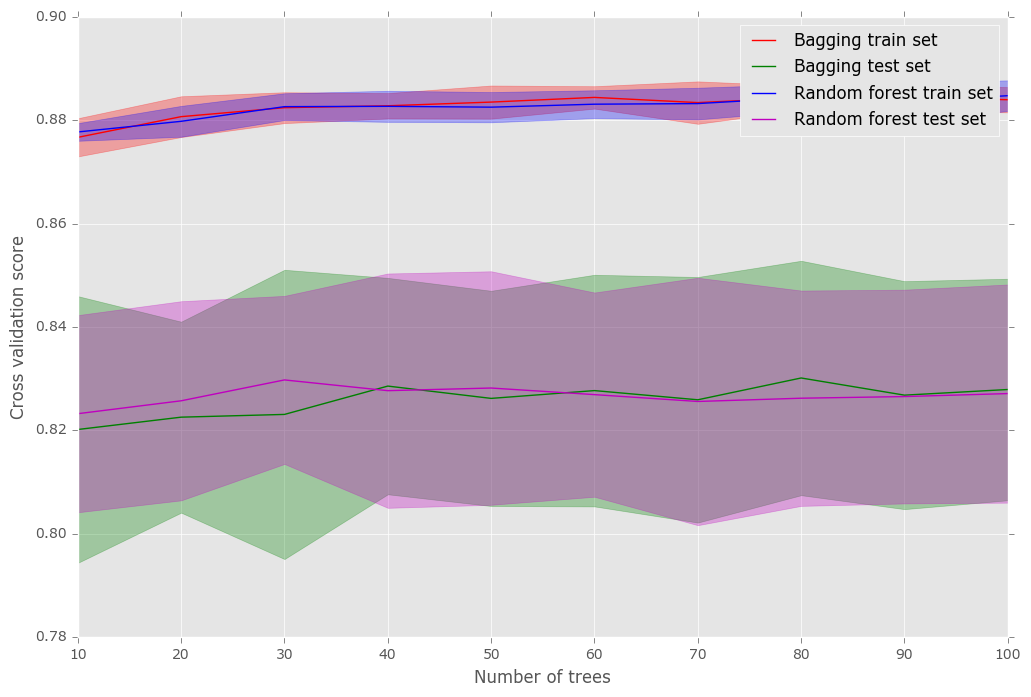

In [13]:
# Your Code Here
model = DecisionTreeClassifier(max_depth=bestDepth)
baggingModel=BaggingClassifier(base_estimator=model)
randomForestModel=RandomForestClassifier(max_depth=bestDepth)
modelCountRange=range(10,101, 10);
btrss,btess=validation_curve(baggingModel,X,Y,'n_estimators',modelCountRange, n_jobs=-1, cv=5, scoring='roc_auc')
rftrss,rftess=validation_curve(baggingModel,X,Y,'n_estimators',modelCountRange, n_jobs=-1, cv=5, scoring='roc_auc')

meanBtrss,meanBtess,meanRftrss,meanRftess=btrss.mean(axis=1),btess.mean(axis=1),rftrss.mean(axis=1),rftess.mean(axis=1)
stdBtrss,stdBtess,stdRftrss,stdRftess=btrss.std(axis=1),btess.std(axis=1),rftrss.std(axis=1),rftess.std(axis=1)

plt.plot(modelCountRange,meanBtrss,color='r',label="Bagging train set")
plt.plot(modelCountRange,meanBtess,color='g',label="Bagging test set")
plt.plot(modelCountRange,meanRftrss,color='b',label="Random forest train set")
plt.plot(modelCountRange,meanRftess,color='m',label="Random forest test set")

plt.fill_between(modelCountRange,meanBtrss-stdBtrss,meanBtrss+stdBtrss,color='r',alpha=0.3)
plt.fill_between(modelCountRange,meanBtess-stdBtess,meanBtess+stdBtess,color='g',alpha=0.3)
plt.fill_between(modelCountRange,meanRftrss-stdRftrss,meanRftrss+stdRftrss,color='b',alpha=0.3)
plt.fill_between(modelCountRange,meanRftess-stdRftess,meanRftess+stdRftess,color='m',alpha=0.3)
plt.legend()
plt.xlabel('Number of trees')
plt.ylabel('Cross validation score')


Методы бэггинга и случайного дерева работают примерно одинаково, так же при количестве деревьев больше 30 качество классификации существенно не улучшается.

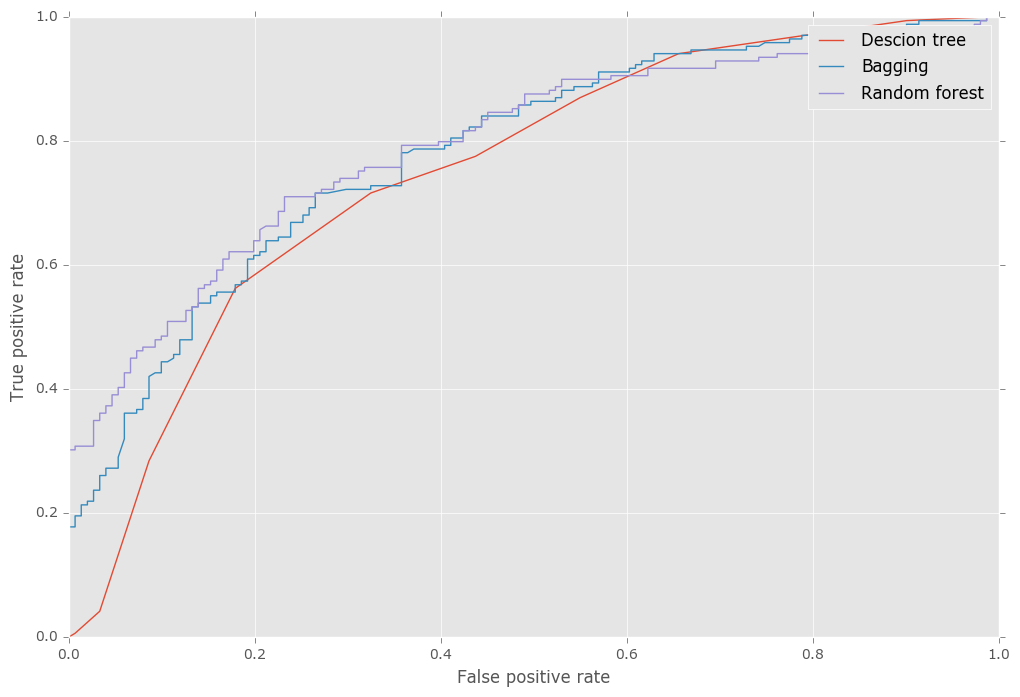

In [14]:
from sklearn.metrics import roc_curve

model = DecisionTreeClassifier(max_depth=bestDepth).fit(X_train,Y_train)
baggingModel=BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=bestDepth),n_estimators=30).fit(X_train,Y_train)
randomForestModel=RandomForestClassifier(max_depth=bestDepth,n_estimators=30).fit(X_train,Y_train)

pred_tree=model.predict_proba(X_test)
pred_bagging=baggingModel.predict_proba(X_test)
pred_randForest=randomForestModel.predict_proba(X_test)

tree_roc=roc_curve(Y_test,pred_tree[:,1])
bagging_roc=roc_curve(Y_test,pred_bagging[:,1])
randForest_roc=roc_curve(Y_test,pred_randForest[:,1])

plt.plot(tree_roc[0],tree_roc[1])
plt.plot(bagging_roc[0],bagging_roc[1])
plt.plot(randForest_roc[0],randForest_roc[1])
plt.legend(["Descion tree","Bagging","Random forest"])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

Методы бэггинга и рандомных деревьев показывают себя лучше чем одно решающее дерево.

####  Задание (3 балла)
* С помощью `GridSearchCV` или `RandomSearchCV` подберите наиболее оптимальные параметры для случайного леса.
* Для этих параметров сравните средние результаты по кросс-валидации и качество на контрольной выборке

In [15]:
# Your Code Here
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
forest = RandomForestClassifier()
param_grid = {'n_estimators': range(10,101,10), 'max_depth': range(1,30)}
grid= GridSearchCV(estimator=forest, param_grid=param_grid, cv=5, scoring='roc_auc')

grid.fit(X=X_train, y=Y_train)
print("The best params:\nMax depth: "+str(grid.best_params_["max_depth"])+"\nTree count: "+str(grid.best_params_["n_estimators"]))

The best params:
Max depth: 16
Tree count: 90


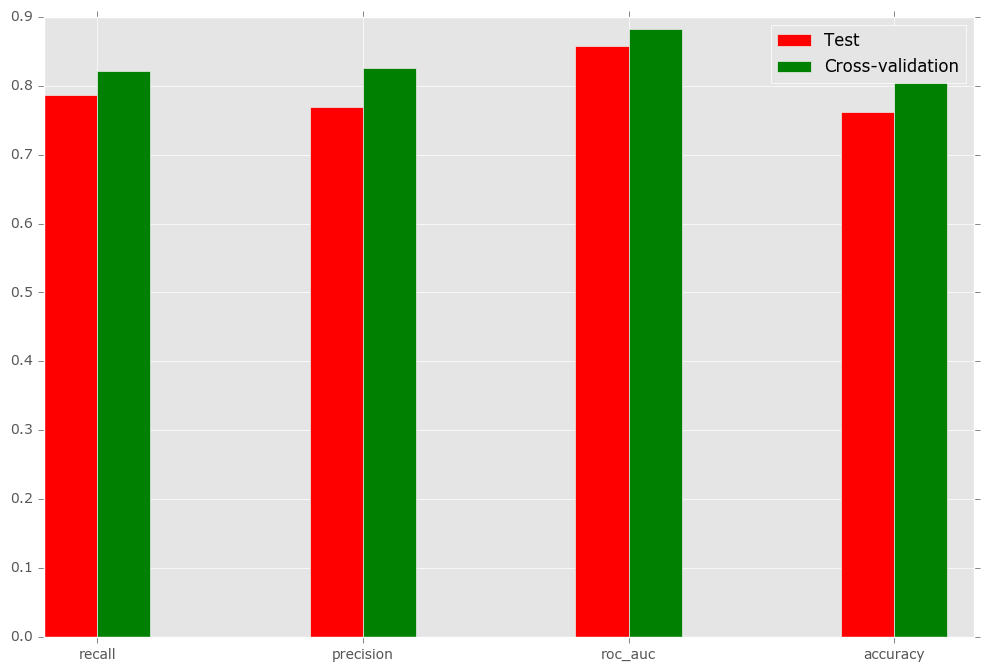

In [16]:
from sklearn.metrics import roc_auc_score,accuracy_score,recall_score,precision_score

Y_test_pred=grid.best_estimator_.predict(X_test)
Y_test_prodpred=grid.best_estimator_.predict_proba(X_test)[:,1]

test_scores={}
test_scores["roc_auc"]=roc_auc_score(Y_test, Y_test_prodpred)
test_scores["accuracy"]=accuracy_score(Y_test,Y_test_pred)
test_scores["recall"]=recall_score(Y_test,Y_test_pred)
test_scores["precision"]=precision_score(Y_test,Y_test_pred)

cross_val_scores={}
cross_val_scores["roc_auc"]=cross_val_score(grid.best_estimator_, X_train, Y_train,cv=5, scoring='roc_auc').mean()
cross_val_scores["accuracy"]=cross_val_score(grid.best_estimator_, X_train, Y_train,cv=5, scoring='accuracy').mean()
cross_val_scores["recall"]=cross_val_score(grid.best_estimator_, X_train, Y_train,cv=5, scoring='recall').mean()
cross_val_scores["precision"]=cross_val_score(grid.best_estimator_, X_train, Y_train,cv=5, scoring='precision').mean()


width=0.2
ind=np.arange(len(test_scores))
plt.bar(ind,test_scores.values(),width,label="Test",color='r')
plt.bar(ind+width,cross_val_scores.values(),width,label="Cross-validation",color='g')
plt.xticks(ind + width, test_scores.keys())
plt.legend()

Значения при кросс-валидации лишь незначительно больше, чем на контрольной выборке, откуда ясно, что наша модель не переобучена.